In [3]:
%pip install nibabel opencv-python tqdm matplotlib torch torchvision scikit-image 

Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
import numpy as np
import cv2

print(f"Python: {sys.version}")
print(f"NumPy: {np.__version__}")
print(f"OpenCV: {cv2.__version__}")

# Should show:
# NumPy: 1.26.x (NOT 2.x)
# OpenCV: 4.8.1

Python: 3.12.11 | packaged by conda-forge | (main, Jun  4 2025, 14:38:53) [Clang 18.1.8 ]
NumPy: 1.26.4
OpenCV: 4.8.1


In [3]:
import os
import glob
import math
import random
import numpy as np
import nibabel as nib
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Check versions
print(f"NumPy: {np.__version__}")
print(f"OpenCV: {cv2.__version__}")
print(f"PyTorch: {torch.__version__}")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nUsing device: {DEVICE}")

NumPy: 1.26.4
OpenCV: 4.8.1
PyTorch: 2.3.1

Using device: cpu


In [31]:
RAW_DIR = "IXI-T1"  
PROC_DIR = "data/sr_pairs"  

# Create directories
os.makedirs(os.path.join(PROC_DIR, "HR"), exist_ok=True)
os.makedirs(os.path.join(PROC_DIR, "LR"), exist_ok=True)

# Data preprocessing settings
SCALE = 4              
HR_SIZE = 256          
MAX_VOLUMES = 30       
SLICE_STEP = 3         
MIN_SLICE_STD = 8      

# Training settings
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-3
VAL_SPLIT = 0.1
RANDOM_SEED = 42

# Set seeds for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

print(f"Configuration set:")
print(f"  Scale: {SCALE}x")
print(f"  HR size: {HR_SIZE}x{HR_SIZE}")
print(f"  LR size: {HR_SIZE//SCALE}x{HR_SIZE//SCALE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")

Configuration set:
  Scale: 4x
  HR size: 256x256
  LR size: 64x64
  Batch size: 32
  Epochs: 10


##  Metric Functions

In [33]:
def psnr(gt, pred, data_range=255.0):
    """Calculate Peak Signal-to-Noise Ratio."""
    gt = gt.astype(np.float64)
    pred = pred.astype(np.float64)
    mse = np.mean((gt - pred) ** 2)
    if mse == 0:
        return float("inf")
    return 20.0 * np.log10(data_range) - 10.0 * np.log10(mse)


def ssim(gt, pred, data_range=255.0):
    """Calculate Structural Similarity Index."""
    gt = gt.astype(np.float64)
    pred = pred.astype(np.float64)
    K1, K2 = 0.01, 0.03
    C1 = (K1 * data_range) ** 2
    C2 = (K2 * data_range) ** 2

    mu_x, mu_y = gt.mean(), pred.mean()
    var_x, var_y = gt.var(), pred.var()
    cov_xy = ((gt - mu_x) * (pred - mu_y)).mean()

    num = (2 * mu_x * mu_y + C1) * (2 * cov_xy + C2)
    den = (mu_x**2 + mu_y**2 + C1) * (var_x + var_y + C2)
    return float(num / den)


print("Metric functions defined.")

Metric functions defined.


## Data Preprocessing Functions

In [35]:
def normalize_to_uint8(img2d):
    """Normalize slice to [0, 255] with percentile clipping."""
    img2d = img2d.astype(np.float32)
    lo, hi = np.percentile(img2d, 1), np.percentile(img2d, 99)
    img2d = np.clip((img2d - lo) / (hi - lo + 1e-8), 0, 1)
    return (img2d * 255.0).astype(np.uint8)


def center_crop_and_resize(img, size, divisible_by):
    """Resize to square and crop to be divisible by scale factor."""
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
    cut = size - (size % divisible_by)
    offset = (size - cut) // 2
    return img[offset:offset+cut, offset:offset+cut]


print("Preprocessing functions defined.")

Preprocessing functions defined.


## Process NIfTI Dataset

In [37]:
# Find all NIfTI files
nii_paths = sorted(glob.glob(os.path.join(RAW_DIR, "*.nii*")))[:MAX_VOLUMES]
print(f"Found {len(nii_paths)} NIfTI volumes in {RAW_DIR}")

if len(nii_paths) == 0:
    print(f"ERROR: No .nii or .nii.gz files found in {RAW_DIR}")
    print("Please make sure your IXI dataset is in the correct folder.")
else:
    saved = 0
    for p in tqdm(nii_paths, desc="Processing volumes"):
        # Load 3D volume
        vol = nib.load(p).get_fdata()
        
        # Process each slice
        for z in range(0, vol.shape[2], SLICE_STEP):
            sl = vol[:, :, z]
            
            # Skip slices with low contrast
            if np.std(sl) < MIN_SLICE_STD:
                continue
            
            # Normalize and resize
            sl_norm = normalize_to_uint8(sl)
            hr = center_crop_and_resize(sl_norm, HR_SIZE, SCALE)
            
            # Create LR version by downsampling
            lr_small = cv2.resize(
                hr,
                (hr.shape[1] // SCALE, hr.shape[0] // SCALE),
                interpolation=cv2.INTER_CUBIC
            )
            
            # Save images
            base = os.path.splitext(os.path.basename(p))[0]
            fname = f"{base}_z{z:03d}.png"
            
            cv2.imwrite(os.path.join(PROC_DIR, "HR", fname), hr)
            cv2.imwrite(os.path.join(PROC_DIR, "LR", fname), lr_small)
            saved += 1
    
    print(f"\nSaved {saved} LR/HR image pairs to {PROC_DIR}")

Found 30 NIfTI volumes in IXI-T1


Processing volumes: 100%|███████████████████████| 30/30 [00:04<00:00,  6.56it/s]


Saved 1444 LR/HR image pairs to data/sr_pairs


## Dataset Class

In [39]:
class SRDataset(Dataset):
    """Super-Resolution Dataset."""
    
    def __init__(self, root_dir, split="train", val_split=0.1, seed=42):
        hr_dir = os.path.join(root_dir, "HR")
        lr_dir = os.path.join(root_dir, "LR")
        
        # Get all HR images
        self.hr_paths = sorted(glob.glob(os.path.join(hr_dir, "*.png")))
        self.lr_paths = [os.path.join(lr_dir, os.path.basename(p)) for p in self.hr_paths]
        
        # Split into train/val
        rng = np.random.RandomState(seed)
        idxs = np.arange(len(self.hr_paths))
        rng.shuffle(idxs)
        val_n = int(len(idxs) * val_split)
        val_idxs = set(idxs[:val_n])
        
        if split == "train":
            self.idxs = [i for i in idxs if i not in val_idxs]
        else:
            self.idxs = [i for i in idxs if i in val_idxs]
    
    def __len__(self):
        return len(self.idxs)
    
    def __getitem__(self, i):
        idx = self.idxs[i]
        
        # Load images
        hr = cv2.imread(self.hr_paths[idx], cv2.IMREAD_GRAYSCALE)
        lr_small = cv2.imread(self.lr_paths[idx], cv2.IMREAD_GRAYSCALE)
        
        # Upsample LR to HR size (bicubic interpolation)
        lr_up = cv2.resize(lr_small, (hr.shape[1], hr.shape[0]), 
                          interpolation=cv2.INTER_CUBIC)
        
        # Convert to tensors [0, 1]
        hr_t = torch.from_numpy(hr).float().unsqueeze(0) / 255.0
        lr_t = torch.from_numpy(lr_up).float().unsqueeze(0) / 255.0
        
        return lr_t, hr_t


# Create datasets
train_ds = SRDataset(PROC_DIR, split="train", val_split=VAL_SPLIT, seed=RANDOM_SEED)
val_ds = SRDataset(PROC_DIR, split="val", val_split=VAL_SPLIT, seed=RANDOM_SEED)

# Create dataloaders
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, 
                     num_workers=0, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, 
                   num_workers=0, pin_memory=True)

print(f"Dataset created:")
print(f"  Training samples: {len(train_ds)}")
print(f"  Validation samples: {len(val_ds)}")
print(f"  Training batches: {len(train_dl)}")
print(f"  Validation batches: {len(val_dl)}")

Dataset created:
  Training samples: 1300
  Validation samples: 144
  Training batches: 41
  Validation batches: 5


## SRCNN Model

In [41]:
class SRCNN(nn.Module):
    """Super-Resolution Convolutional Neural Network."""
    
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # Patch extraction: 9x9 conv, 64 filters
            nn.Conv2d(1, 64, kernel_size=9, padding=4),
            nn.ReLU(inplace=True),
            
            # Non-linear mapping: 5x5 conv, 32 filters
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            
            # Reconstruction: 5x5 conv, 1 filter
            nn.Conv2d(32, 1, kernel_size=5, padding=2)
        )
    
    def forward(self, x):
        return self.net(x)


# Create model
model = SRCNN().to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Model: SRCNN")
print(f"Parameters: {total_params:,}")
print(f"Device: {DEVICE}")

Model: SRCNN
Parameters: 57,281
Device: cpu


## Loss, Optimizer, Scheduler

In [43]:
# Loss function
criterion = nn.L1Loss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, verbose=True
)

print("Training setup complete:")
print(f"  Loss: L1Loss")
print(f"  Optimizer: Adam (lr={LEARNING_RATE})")
print(f"  Scheduler: ReduceLROnPlateau")

Training setup complete:
  Loss: L1Loss
  Optimizer: Adam (lr=0.001)
  Scheduler: ReduceLROnPlateau


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## Training Functions

In [45]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0.0
    
    for lr_batch, hr_batch in tqdm(dataloader, desc="Training", leave=False):
        lr_batch = lr_batch.to(device)
        hr_batch = hr_batch.to(device)
        
        # Forward
        optimizer.zero_grad()
        sr_batch = model(lr_batch)
        loss = criterion(sr_batch, hr_batch)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)


def validate(model, dataloader, device):
    """Validate and compute metrics."""
    model.eval()
    psnr_vals = []
    ssim_vals = []
    
    with torch.no_grad():
        for lr_batch, hr_batch in tqdm(dataloader, desc="Validating", leave=False):
            lr_batch = lr_batch.to(device)
            hr_batch = hr_batch.to(device)
            
            sr_batch = model(lr_batch)
            
            # Convert to numpy for metrics
            sr_np = (sr_batch.cpu().numpy() * 255.0).astype(np.uint8)
            hr_np = (hr_batch.cpu().numpy() * 255.0).astype(np.uint8)
            
            for i in range(sr_np.shape[0]):
                psnr_vals.append(psnr(hr_np[i, 0], sr_np[i, 0]))
                ssim_vals.append(ssim(hr_np[i, 0], sr_np[i, 0]))
    
    return np.mean(psnr_vals), np.mean(ssim_vals)


print("Training functions defined.")

Training functions defined.


## Training Loop

In [47]:
# Training history
history = {
    'train_loss': [],
    'val_psnr': [],
    'val_ssim': [],
    'lr': []
}

best_psnr = 0.0
save_path = "srcnn_best.pth"

print(f"\nStarting training for {EPOCHS} epochs...")
print("="*70)

for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss = train_epoch(model, train_dl, criterion, optimizer, DEVICE)
    
    # Validate
    val_psnr_val, val_ssim_val = validate(model, val_dl, DEVICE)
    
    # Update scheduler
    scheduler.step(val_psnr_val)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['val_psnr'].append(val_psnr_val)
    history['val_ssim'].append(val_ssim_val)
    history['lr'].append(current_lr)
    
    # Print progress
    print(f"Epoch {epoch:2d}/{EPOCHS} | "
          f"Loss: {train_loss:.4f} | "
          f"PSNR: {val_psnr_val:.2f} dB | "
          f"SSIM: {val_ssim_val:.4f} | "
          f"LR: {current_lr:.6f}")
    
    # Save best model
    if val_psnr_val > best_psnr:
        best_psnr = val_psnr_val
        torch.save(model.state_dict(), save_path)
        print(f"  → Best model saved (PSNR: {best_psnr:.2f} dB)")

print(f"Training complete! Best PSNR: {best_psnr:.2f} dB")
print(f"Model saved to: {save_path}")


Starting training for 10 epochs...


Epoch  1/10 | Loss: 0.0569 | PSNR: 17.45 dB | SSIM: 0.8640 | LR: 0.001000
  → Best model saved (PSNR: 17.45 dB)


Epoch  2/10 | Loss: 0.0383 | PSNR: 22.82 dB | SSIM: 0.9556 | LR: 0.001000
  → Best model saved (PSNR: 22.82 dB)


Epoch  3/10 | Loss: 0.0370 | PSNR: 22.22 dB | SSIM: 0.9487 | LR: 0.001000


Epoch  4/10 | Loss: 0.0365 | PSNR: 21.31 dB | SSIM: 0.9382 | LR: 0.001000


Epoch  5/10 | Loss: 0.0366 | PSNR: 22.35 dB | SSIM: 0.9510 | LR: 0.001000


Epoch  6/10 | Loss: 0.0363 | PSNR: 22.28 dB | SSIM: 0.9500 | LR: 0.001000


Epoch  7/10 | Loss: 0.0358 | PSNR: 22.38 dB | SSIM: 0.9506 | LR: 0.001000


Epoch  8/10 | Loss: 0.0357 | PSNR: 22.43 dB | SSIM: 0.9518 | LR: 0.000500


Epoch  9/10 | Loss: 0.0353 | PSNR: 22.83 dB | SSIM: 0.9558 | LR: 0.000500
  → Best model saved (PSNR: 22.83 dB)


Epoch 10/10 | Loss: 0.0353 | PSNR: 22.79 dB | SSIM: 0.9554 | LR: 0.000500
Training complete! Best PSNR: 22.83 dB
Model saved to: srcnn_best.pth


## Plot Training History

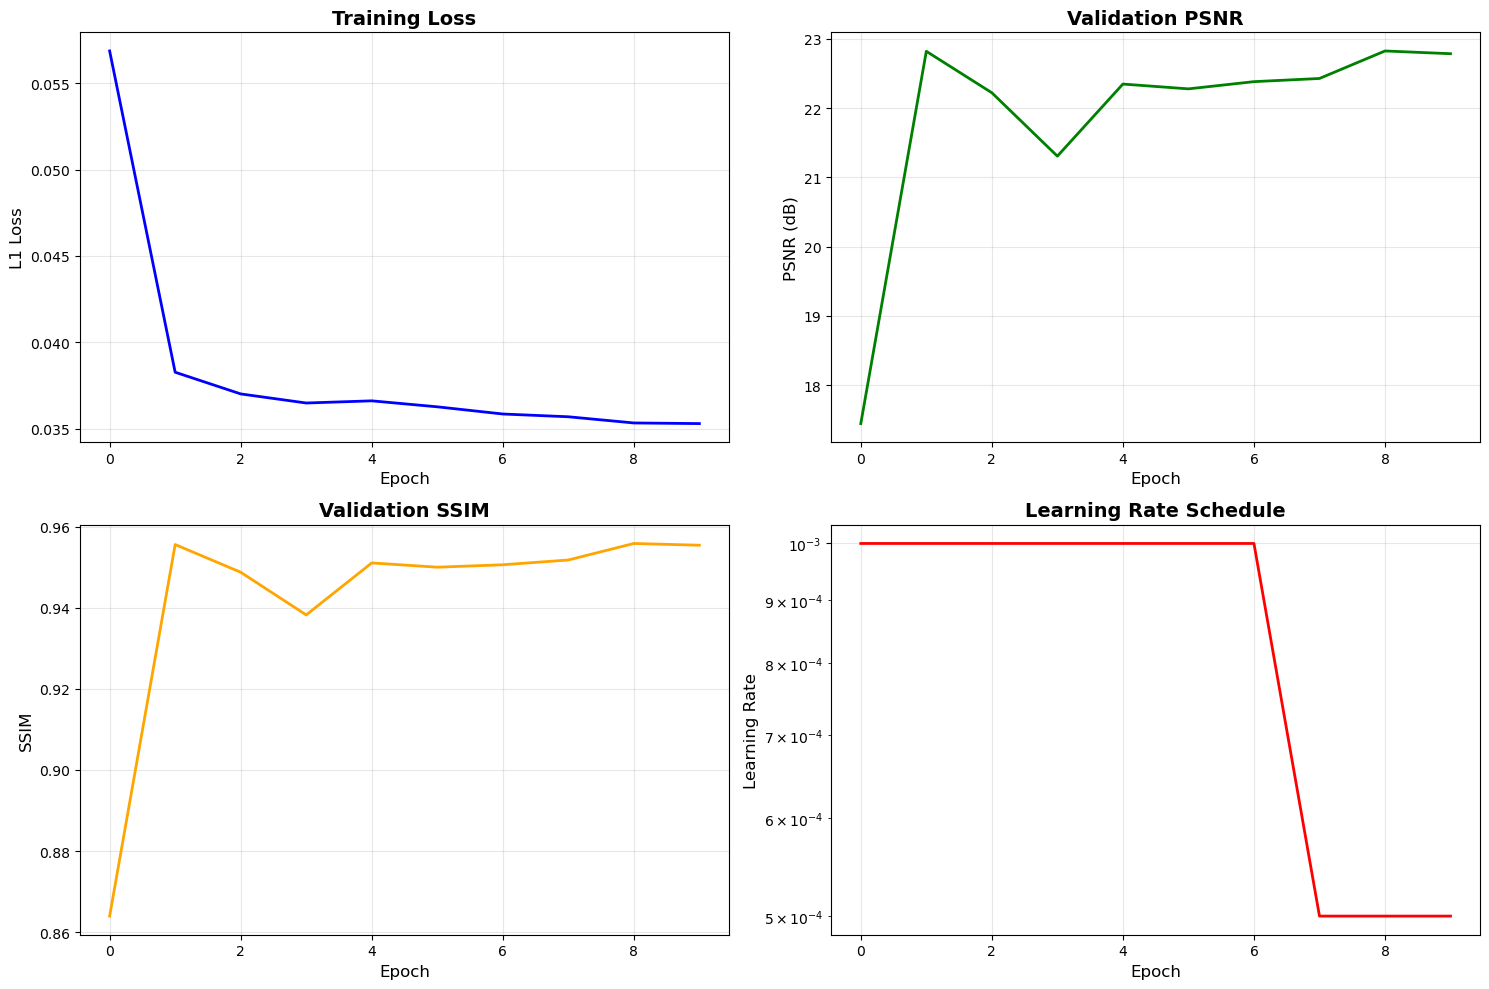

Training history plot saved to: training_history.png


In [50]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training loss
axes[0, 0].plot(history['train_loss'], linewidth=2, color='blue')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('L1 Loss', fontsize=12)
axes[0, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Validation PSNR
axes[0, 1].plot(history['val_psnr'], linewidth=2, color='green')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('PSNR (dB)', fontsize=12)
axes[0, 1].set_title('Validation PSNR', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Validation SSIM
axes[1, 0].plot(history['val_ssim'], linewidth=2, color='orange')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('SSIM', fontsize=12)
axes[1, 0].set_title('Validation SSIM', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Learning rate
axes[1, 1].plot(history['lr'], linewidth=2, color='red')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history plot saved to: training_history.png")

## Visualize Results

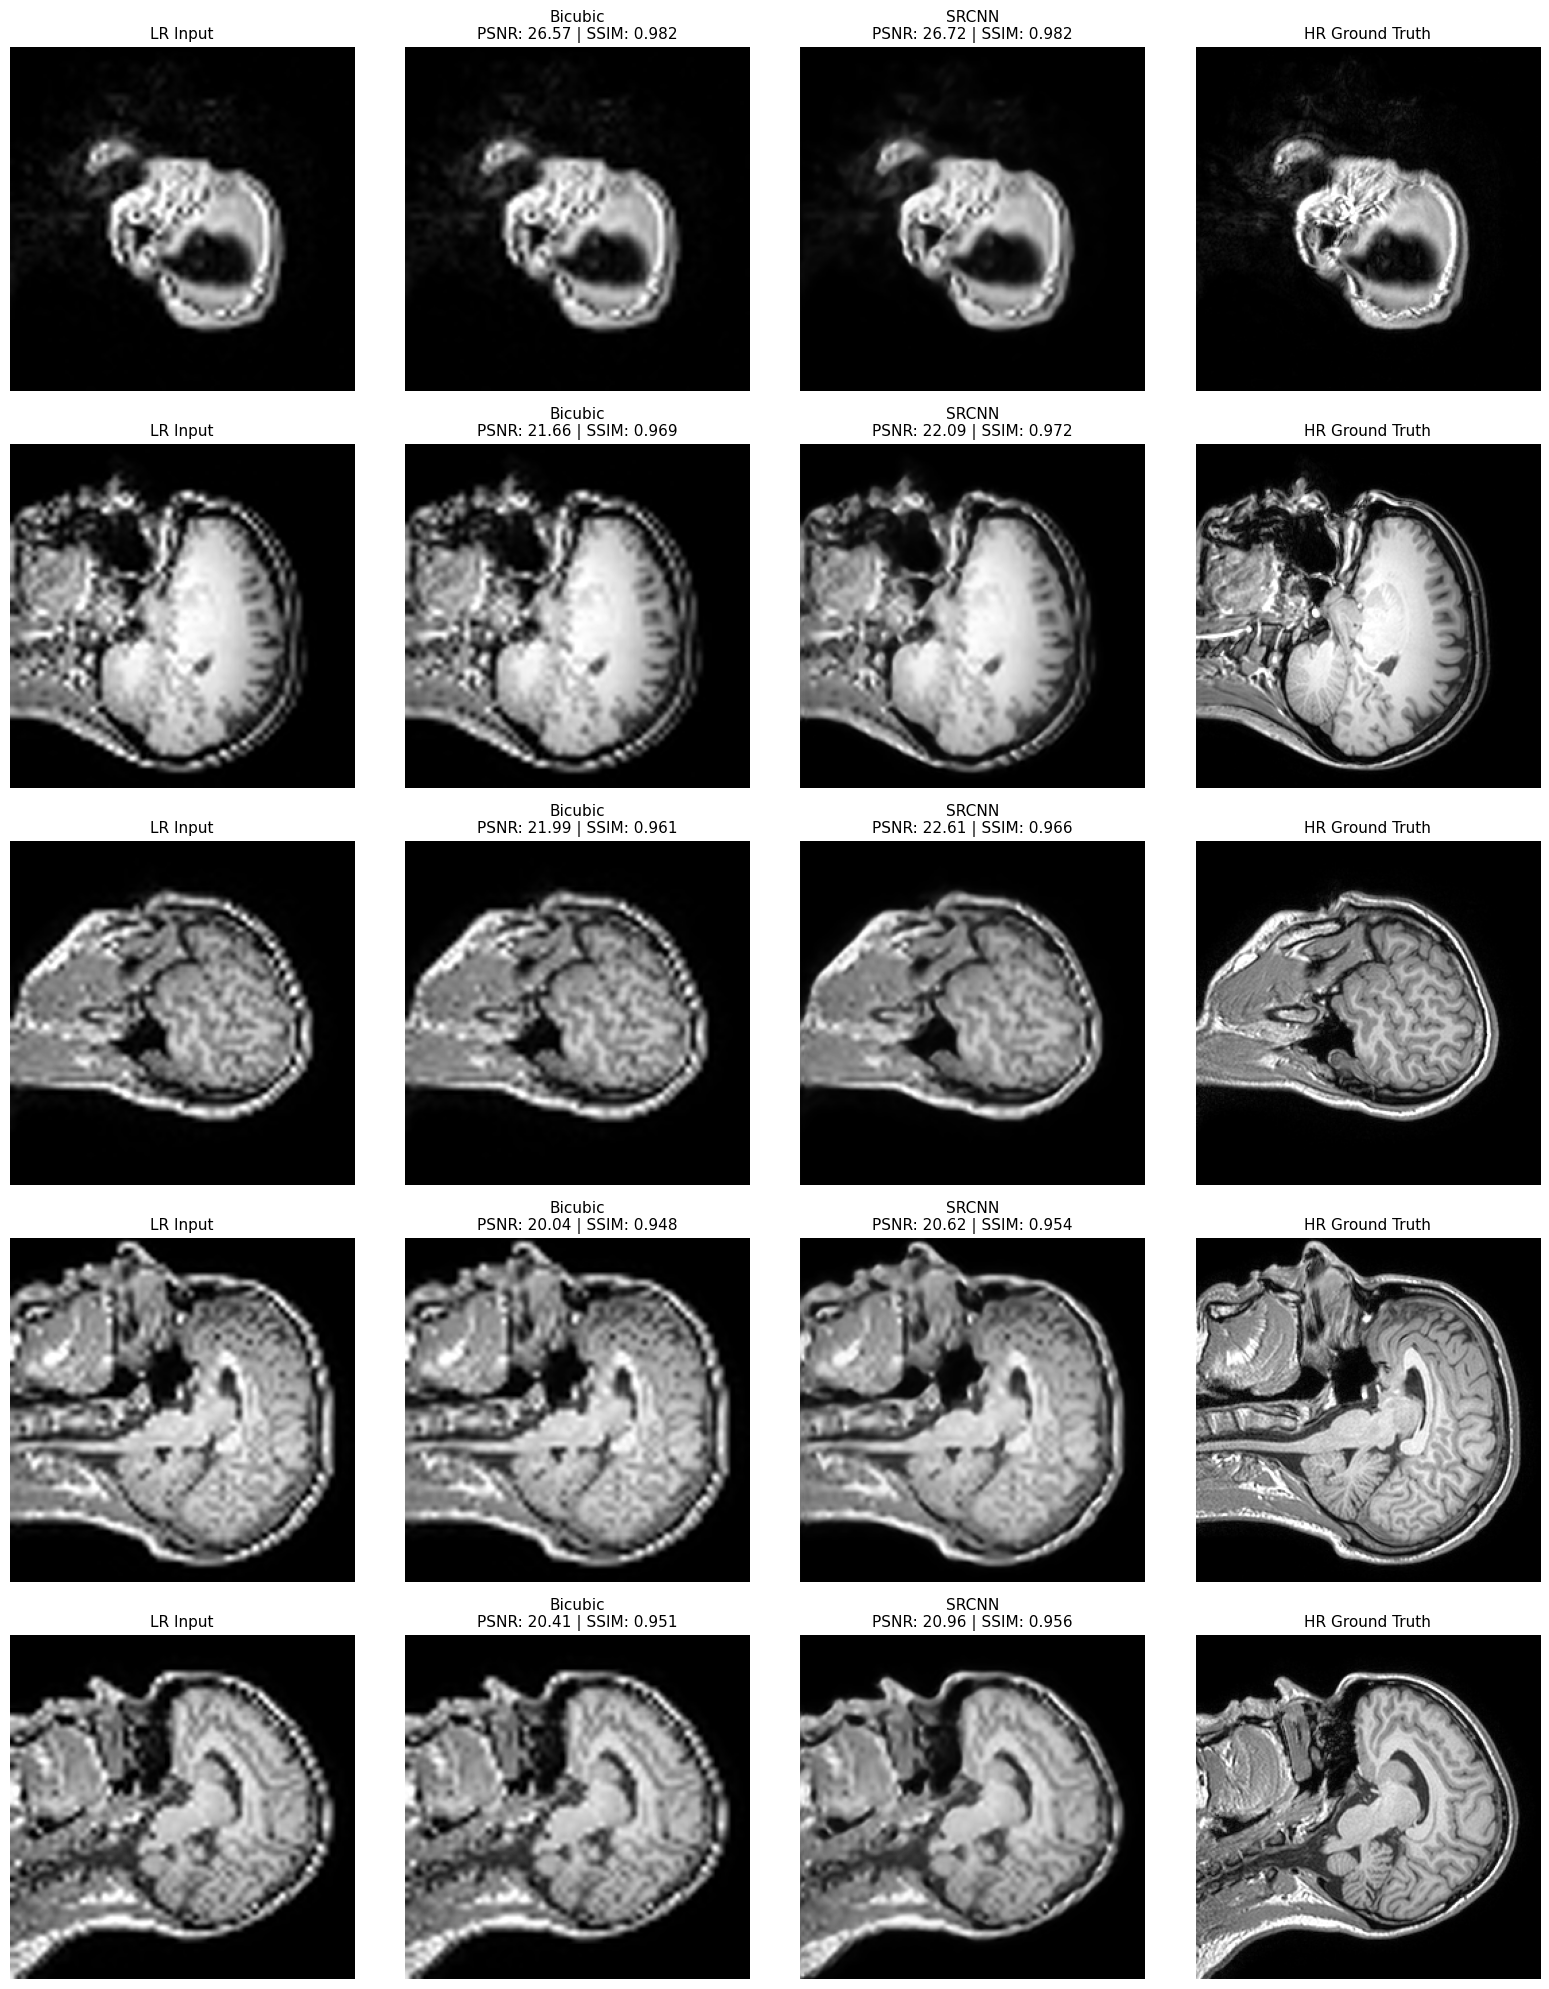

Results visualization saved to: results_comparison.png


In [53]:
def tensor_to_img(t):
    """Convert tensor to image."""
    t = t.detach().cpu().numpy().squeeze()
    t = np.clip(t, 0, 1)
    return (t * 255.0).astype(np.uint8)


# Load best model
model.load_state_dict(torch.load(save_path))
model.eval()

# Select random validation samples
num_samples = 5
indices = random.sample(range(len(val_ds)), num_samples)

fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))

for row, idx in enumerate(indices):
    lr_t, hr_t = val_ds[idx]
    
    # Generate SR
    with torch.no_grad():
        sr_t = model(lr_t.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()
    
    # Convert to images
    lr_img = tensor_to_img(lr_t)
    sr_img = tensor_to_img(sr_t)
    hr_img = tensor_to_img(hr_t)
    
    # Bicubic baseline
    lr_small = cv2.resize(lr_img, (lr_img.shape[1]//SCALE, lr_img.shape[0]//SCALE))
    bic_img = cv2.resize(lr_small, (hr_img.shape[1], hr_img.shape[0]), 
                        interpolation=cv2.INTER_CUBIC)
    
    # Calculate metrics
    psnr_bic = psnr(hr_img, bic_img)
    ssim_bic = ssim(hr_img, bic_img)
    psnr_sr = psnr(hr_img, sr_img)
    ssim_sr = ssim(hr_img, sr_img)
    
    # Plot
    axes[row, 0].imshow(lr_img, cmap='gray')
    axes[row, 0].set_title('LR Input', fontsize=11)
    axes[row, 0].axis('off')
    
    axes[row, 1].imshow(bic_img, cmap='gray')
    axes[row, 1].set_title(f'Bicubic\nPSNR: {psnr_bic:.2f} | SSIM: {ssim_bic:.3f}', fontsize=11)
    axes[row, 1].axis('off')
    
    axes[row, 2].imshow(sr_img, cmap='gray')
    axes[row, 2].set_title(f'SRCNN\nPSNR: {psnr_sr:.2f} | SSIM: {ssim_sr:.3f}', fontsize=11)
    axes[row, 2].axis('off')
    
    axes[row, 3].imshow(hr_img, cmap='gray')
    axes[row, 3].set_title('HR Ground Truth', fontsize=11)
    axes[row, 3].axis('off')

plt.tight_layout()
plt.savefig('results_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Results visualization saved to: results_comparison.png")

## Final Evaluation

In [56]:
print("Evaluating on full validation set...")

model.eval()
bicubic_psnr = []
bicubic_ssim = []
srcnn_psnr = []
srcnn_ssim = []

with torch.no_grad():
    for i in tqdm(range(len(val_ds))):
        lr_t, hr_t = val_ds[i]
        
        # Generate SR
        sr_t = model(lr_t.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()
        
        # Convert to images
        hr_img = tensor_to_img(hr_t)
        sr_img = tensor_to_img(sr_t)
        lr_img = tensor_to_img(lr_t)
        
        # Bicubic baseline
        lr_small = cv2.resize(lr_img, (lr_img.shape[1]//SCALE, lr_img.shape[0]//SCALE))
        bic_img = cv2.resize(lr_small, (hr_img.shape[1], hr_img.shape[0]), 
                            interpolation=cv2.INTER_CUBIC)
        
        # Calculate metrics
        bicubic_psnr.append(psnr(hr_img, bic_img))
        bicubic_ssim.append(ssim(hr_img, bic_img))
        srcnn_psnr.append(psnr(hr_img, sr_img))
        srcnn_ssim.append(ssim(hr_img, sr_img))

# Print results
print("FINAL EVALUATION ON VALIDATION SET")
print(f"Bicubic - PSNR: {np.mean(bicubic_psnr):.2f} ± {np.std(bicubic_psnr):.2f} dB")
print(f"Bicubic - SSIM: {np.mean(bicubic_ssim):.4f} ± {np.std(bicubic_ssim):.4f}")
print(f"SRCNN   - PSNR: {np.mean(srcnn_psnr):.2f} ± {np.std(srcnn_psnr):.2f} dB")
print(f"SRCNN   - SSIM: {np.mean(srcnn_ssim):.4f} ± {np.std(srcnn_ssim):.4f}")
print(f"Improvement:")
print(f"  PSNR: +{np.mean(srcnn_psnr) - np.mean(bicubic_psnr):.2f} dB")
print(f"  SSIM: +{np.mean(srcnn_ssim) - np.mean(bicubic_ssim):.4f}")

Evaluating on full validation set...


100%|█████████████████████████████████████████| 144/144 [00:09<00:00, 15.05it/s]

FINAL EVALUATION ON VALIDATION SET
Bicubic - PSNR: 22.89 ± 3.13 dB
Bicubic - SSIM: 0.9569 ± 0.0274
SRCNN   - PSNR: 23.42 ± 3.08 dB
SRCNN   - SSIM: 0.9609 ± 0.0266
Improvement:
  PSNR: +0.53 dB
  SSIM: +0.0040
